### Install Required Packages

In [1]:
! pip install torch torchvision numpy seaborn matplotlib

You should consider upgrading via the '/home/vangelis/.local/share/virtualenvs/machine-learning-msc-sNBHIkKd/bin/python -m pip install --upgrade pip' command.


### Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision.utils import make_grid

%matplotlib inline
plt.rcParams.update({'figure.figsize': (10, 8)})
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Dataset exploration

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images.shape: torch.Size([64, 3, 32, 32])


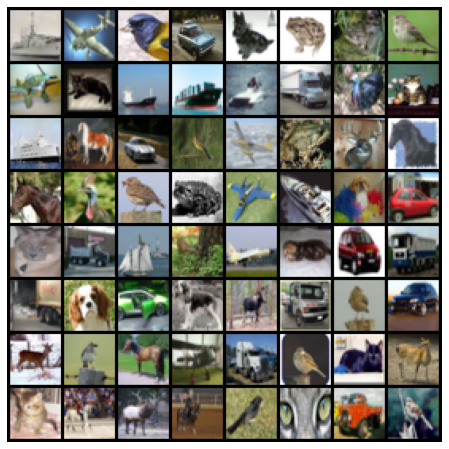

In [3]:
dataset = torchvision.datasets.CIFAR10(root='data/', download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)
print(dataset.classes)

for images, _ in loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break
plt.show()

### Some insights extracted from the dataset exploration

The input of the Neural Network must be 3 * 32 * 32 (images shape) and the output must be equal to 10 (the number of classes).

### Split dataset into train and test set and apply normalizations

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# define the batch size for the dataloaders
batch_size = 64

train_set = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### The Full Connected Neural Network Model

In [5]:
class LeNet5(nn.Module):
    def __init__(self, conv_layer_1, conv_layer_2, dense_layer_1, dense_layer_2, out_layer):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv_layer_1, kernel_size=(3, 3), padding=0, stride=1)
        self.conv2 = nn.Conv2d(in_channels=conv_layer_1, out_channels=conv_layer_2, kernel_size=(3, 3),padding=0, 
                               stride=1)
        self.dense1 = nn.Linear(in_features=36 * conv_layer_2, out_features=dense_layer_1)
        self.dense2 = nn.Linear(in_features=dense_layer_1, out_features=dense_layer_2)
        self.dense3 = nn.Linear(in_features=dense_layer_2, out_features=out_layer)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, padding=0, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, padding=0, stride=2)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)

        return x

### Train and test loops in order to fit & predict data

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= size
    return train_loss


def test_loop(dataloader, model, loss_fn):
    """
    the test loop does not need the optimizer
    we just pass the data through the trained model and measure the error in predictions
    :param dataloader:
    :param model:
    :param loss_fn:
    :return:
    """
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:
            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

### Methods that used to plot error and loss

In [7]:
def plot_losses(history, label):
    plt.plot(history, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'Loss vs. No. of epochs {label} set')
    plt.show()


def plot_accuracies(history, label):
    plt.plot(history, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(f'Accuracy vs. No. of epochs for {label} set')
    plt.show()


### Method that apply train/test loops for a given amount of epochs, learning rate & momentum

In [8]:
def train_nn(model, num_epochs, learning_rate, momentum=0):
    # define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # define the optimizer object
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    train_loss_history = []
    test_loss_history = []
    test_accuracy_history = []

    print(f"Training for learning rate: {learning_rate}, momentum: {momentum}\n")
    for t in range(num_epochs):
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss, accuracy = test_loop(test_dataloader, model, loss_fn)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(accuracy)

    plot_losses(train_loss_history, 'train')
    plot_losses(test_loss_history, 'test')
    plot_accuracies(test_accuracy_history, 'test')
    print(f'Accuracy after {num_epochs} epochs: {test_accuracy_history[num_epochs - 1]}')
    print(f'Loss after {num_epochs} epochs: {test_loss_history[num_epochs - 1]}')

## Training and optimizing Convolutional Neural Network
**1st convolutional layer: 3 -> 16**  
**2nd convolutional layer: 16 -> 32**  
**1st layer: 36 * 32 -> 512**  
**2nd layer: 512 -> 256**  
**3rd layer: 256 -> 10**

### Train and predict for learning_rate=0.001 for 40 epochs

Training for learning rate: 0.001, momentum: 0



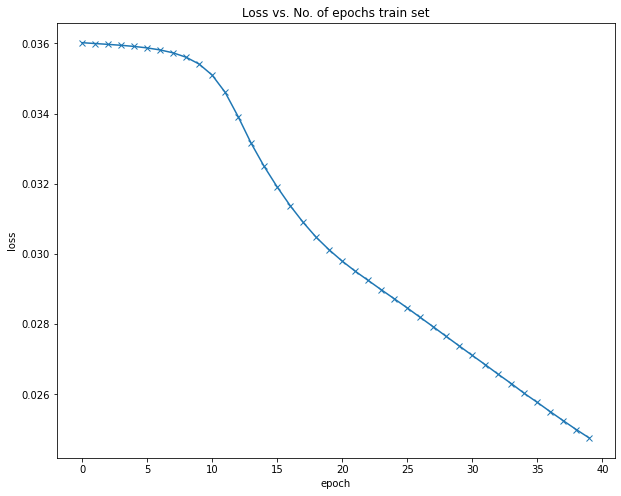

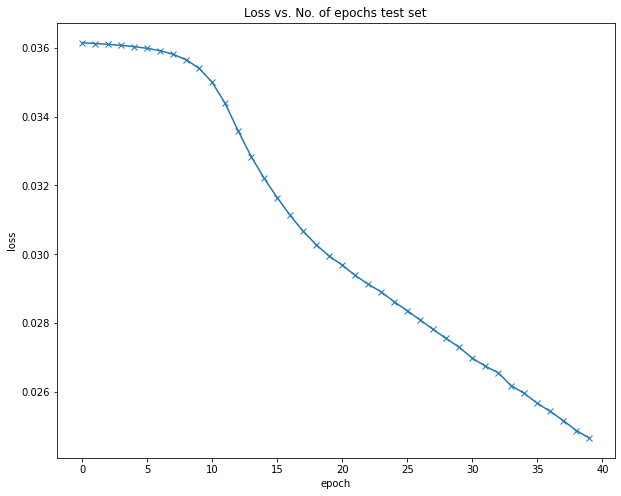

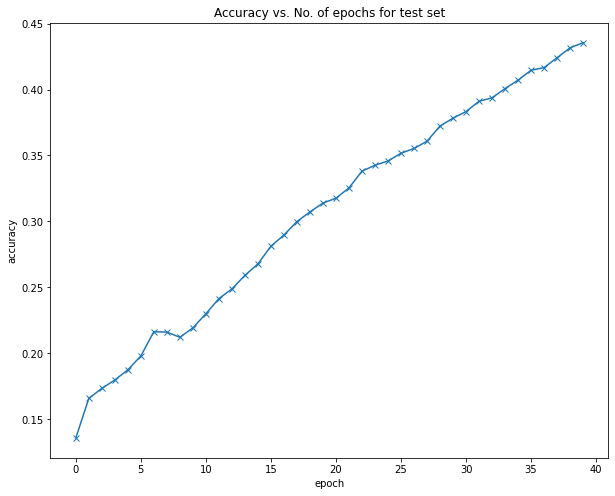

Accuracy after 40 epochs: 0.4355
Loss after 40 epochs: 0.02466564631462097


In [9]:
model = LeNet5(conv_layer_1=16, conv_layer_2=32, dense_layer_1=512, dense_layer_2=256, out_layer=10).to(device)
train_nn(model, num_epochs=40, learning_rate=0.001, momentum=0)

This model for 40 epochs seems to not be converged yet. Although, we will not optimize it further because learning rate of 0.001 seems to be a bit low.

### Train and predict for learning_rate=0.01 for 40 epochs

Training for learning rate: 0.01, momentum: 0



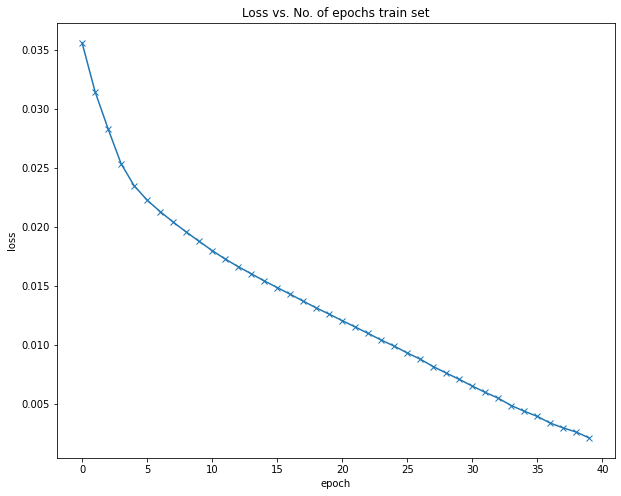

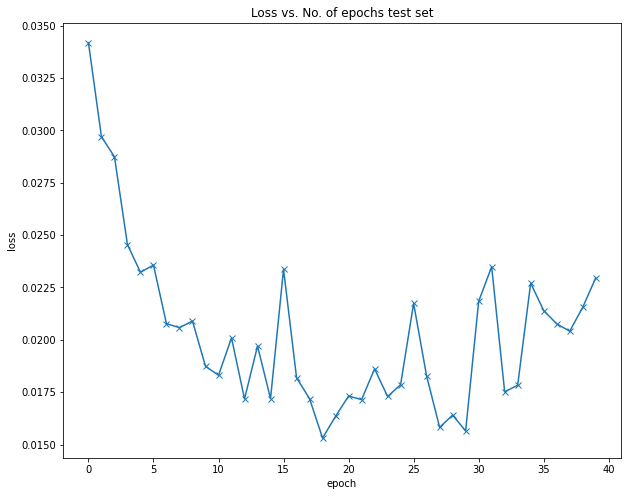

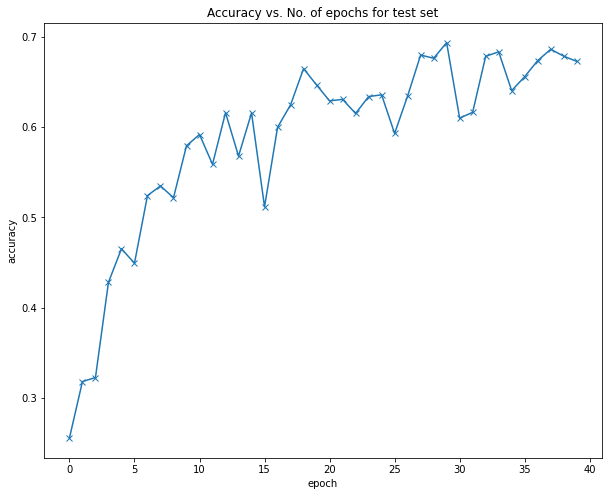

Accuracy after 40 epochs: 0.6725
Loss after 40 epochs: 0.022959005004167556


In [10]:
model = LeNet5(conv_layer_1=16, conv_layer_2=32, dense_layer_1=512, dense_layer_2=256, out_layer=10).to(device)
train_nn(model, num_epochs=40, learning_rate=0.01, momentum=0)

Great accuracy for starters. Τhe loss might be a little increased but it is acceptable (~0.02).

### Train and predict for learning_rate=0.1 for 40 epochs

Training for learning rate: 0.1, momentum: 0



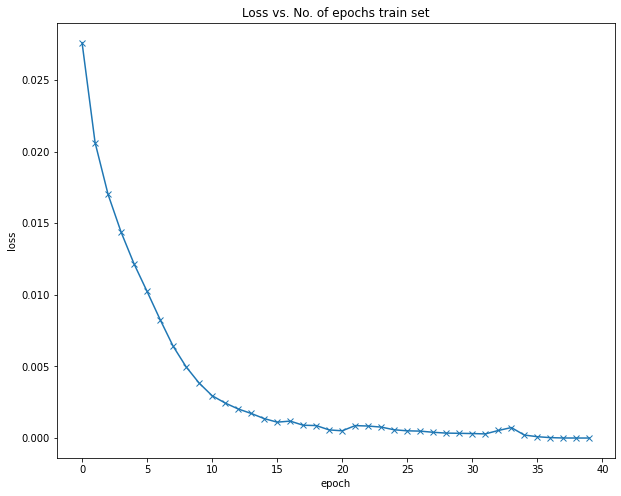

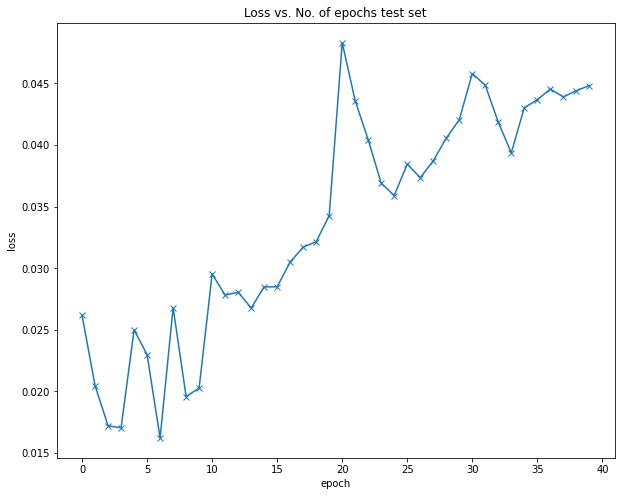

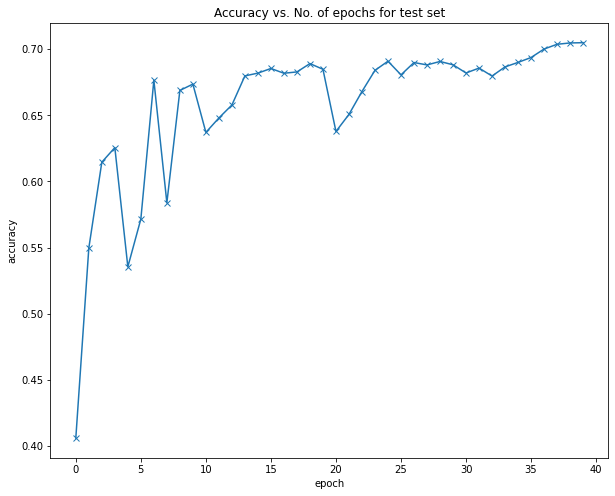

Accuracy after 40 epochs: 0.7049
Loss after 40 epochs: 0.04483457890748978


In [11]:
model = LeNet5(conv_layer_1=16, conv_layer_2=32, dense_layer_1=512, dense_layer_2=256, out_layer=10).to(device)
train_nn(model, num_epochs=40, learning_rate=0.1, momentum=0)

Some observations. The model after epoch 20 is completely converged. The loss for both train and test is stabilized and the accuracy is constant at 71%. Despite the increased accuracy our choice of preference will be learning rate 0.01 because of the low loss.

## Using momentum

The below model configurations are using momentum in the optimizer. This will result to converge in earlier epoch, so the training phases below will use less number of epochs.

### Train and predict for learning_rate=0.01 & momentum=0.2 for 40 epochs

Training for learning rate: 0.01, momentum: 0.2



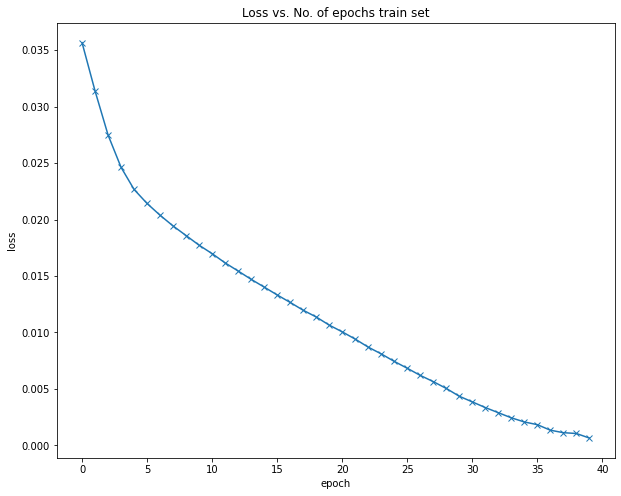

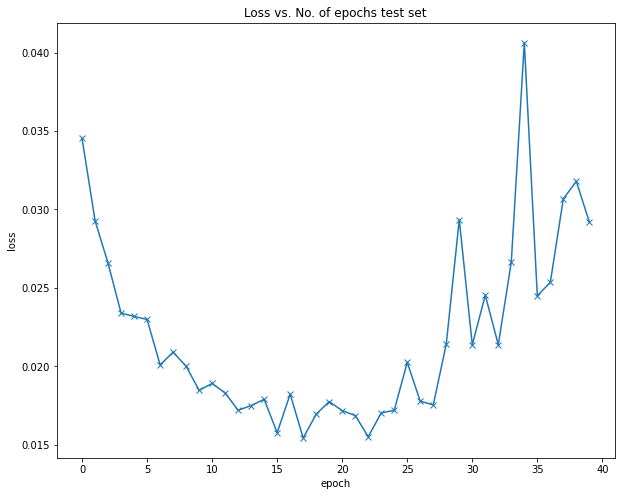

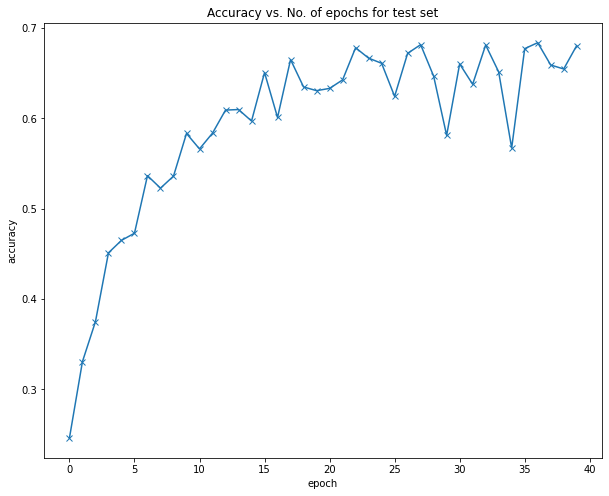

Accuracy after 40 epochs: 0.6805
Loss after 40 epochs: 0.0292031691968441


In [12]:
model = LeNet5(conv_layer_1=16, conv_layer_2=32, dense_layer_1=512, dense_layer_2=256, out_layer=10).to(device)
train_nn(model, num_epochs=40, learning_rate=0.01, momentum=0.2)

### Train and predict for learning_rate=0.01 & momentum=0.5 for 40 epochs

Training for learning rate: 0.01, momentum: 0.5



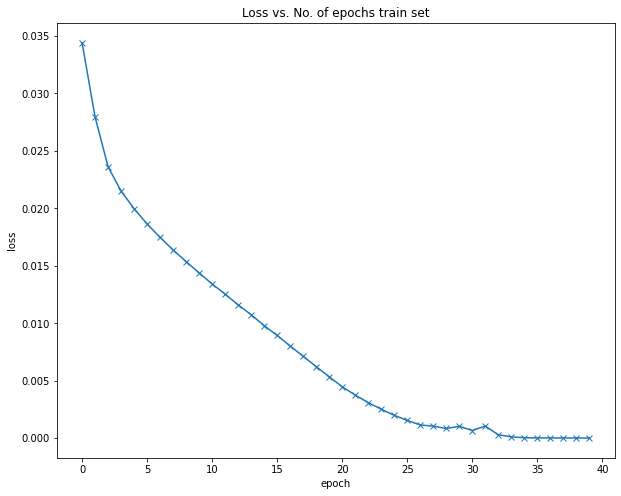

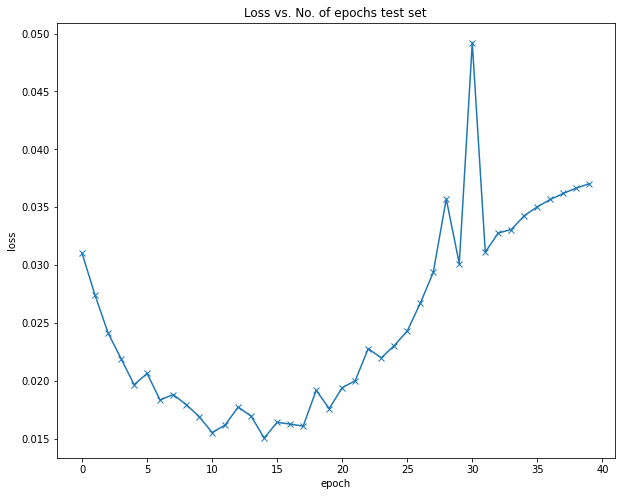

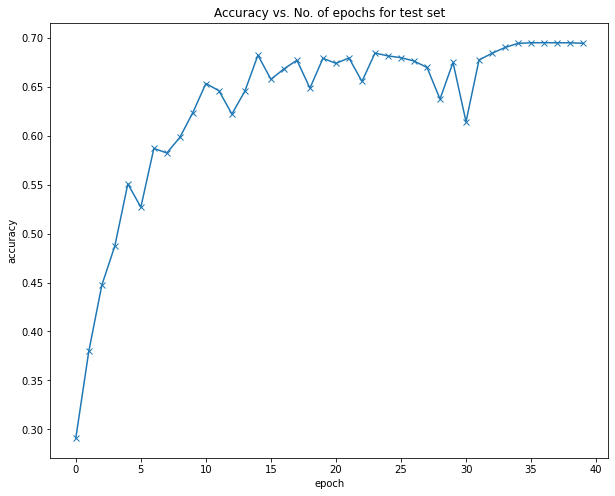

Accuracy after 40 epochs: 0.6943
Loss after 40 epochs: 0.037024630182981494


In [13]:
model = LeNet5(conv_layer_1=16, conv_layer_2=32, dense_layer_1=512, dense_layer_2=256, out_layer=10).to(device)
train_nn(model, num_epochs=40, learning_rate=0.01, momentum=0.5)

## Using different CNN architectures.

### Training Convolutional Neural Network
**1st convolutional layer: 3 -> 32**  
**2nd convolutional layer: 32 -> 64**  
**1st layer: 36 * 64 -> 512**  
**2nd layer: 512 -> 256**  
**3rd layer: 256 -> 10**  
**learning_rate=0.01, momentum=0.9 for 20 epochs**

Training for learning rate: 0.01, momentum: 0.9



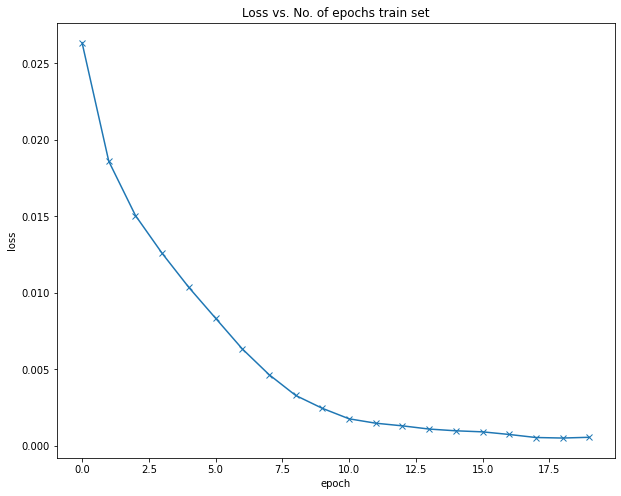

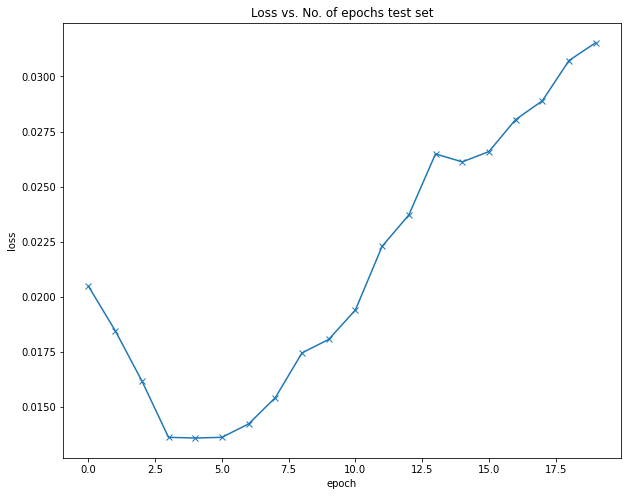

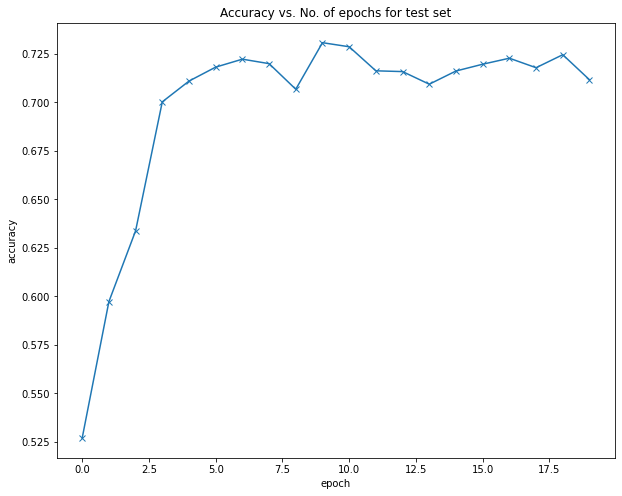

Accuracy after 20 epochs: 0.7116
Loss after 20 epochs: 0.03153647085428238


In [14]:
model = LeNet5(conv_layer_1=32, conv_layer_2=64, dense_layer_1=512, dense_layer_2=256, out_layer=10).to(device)
train_nn(model, num_epochs=20, learning_rate=0.01, momentum=0.9)

### Training Convolutional Neural Network
**1st convolutional layer: 3 -> 64**  
**2nd convolutional layer: 64 -> 128**  
**1st layer: 36 * 128 -> 512**  
**2nd layer: 512 -> 256**  
**3rd layer: 256 -> 10**  
**learning_rate=0.01, momentum=0.9 for 20 epochs**

Training for learning rate: 0.01, momentum: 0.9



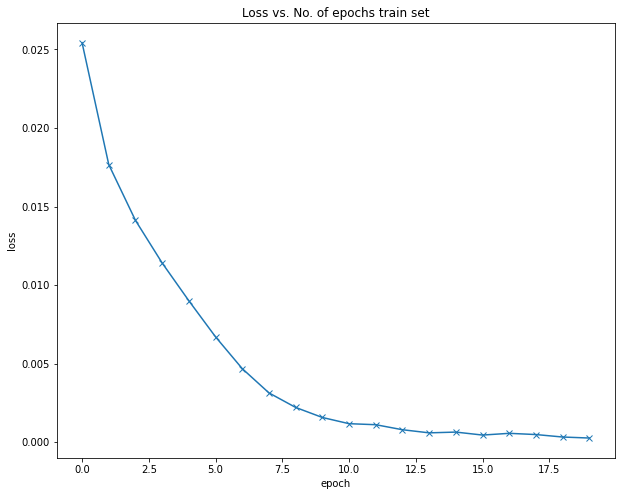

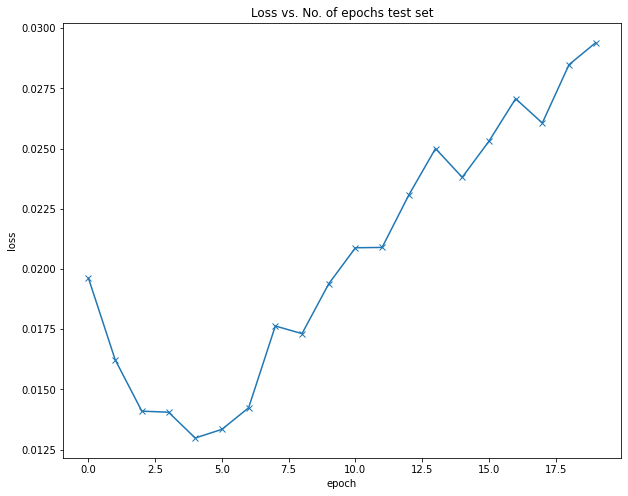

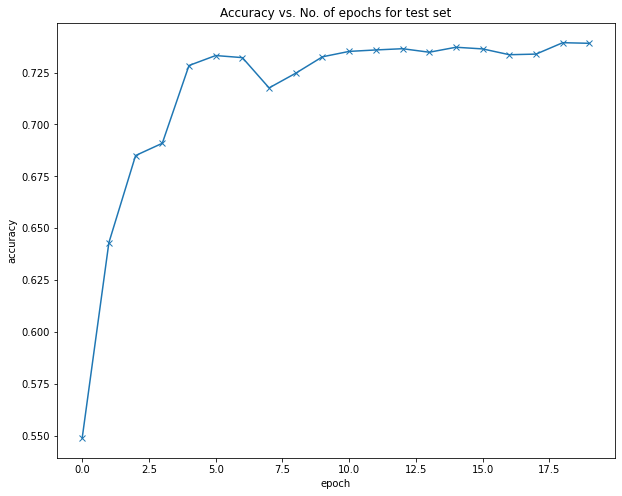

Accuracy after 20 epochs: 0.7391
Loss after 20 epochs: 0.029396746426820754


In [15]:
model = LeNet5(conv_layer_1=64, conv_layer_2=128, dense_layer_1=512, dense_layer_2=256, out_layer=10).to(device)
train_nn(model, num_epochs=20, learning_rate=0.01, momentum=0.9)

### Training Convolutional Neural Network
**1st convolutional layer: 3 -> 64**  
**2nd convolutional layer: 64 -> 128**  
**1st layer: 36 * 128 -> 256**  
**2nd layer: 256 -> 256**  
**3rd layer: 256 -> 10**  
**learning_rate=0.01, momentum=0.9 for 20 epochs**

Training for learning rate: 0.01, momentum: 0.9



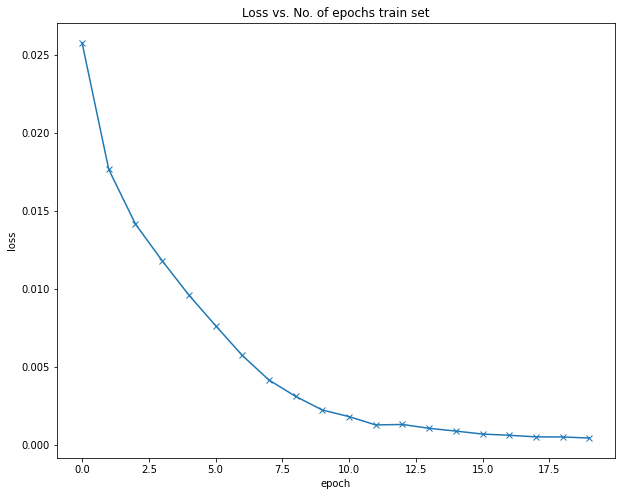

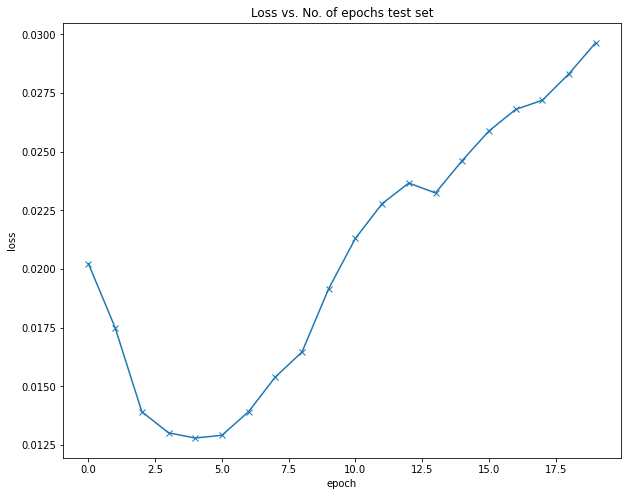

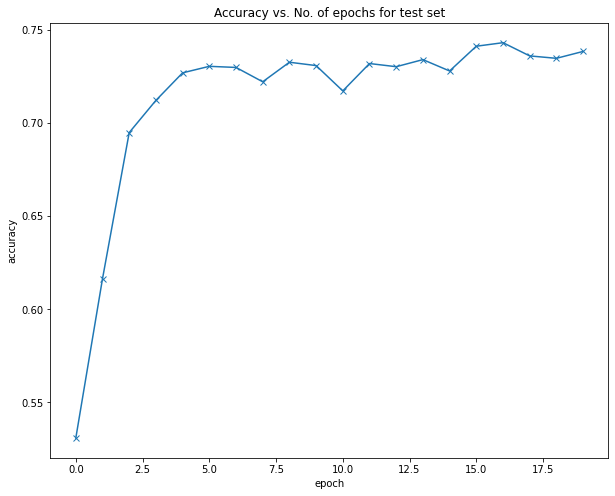

Accuracy after 20 epochs: 0.7385
Loss after 20 epochs: 0.02965052580833435


In [16]:
model = LeNet5(conv_layer_1=64, conv_layer_2=128, dense_layer_1=256, dense_layer_2=256, out_layer=10).to(device)
train_nn(model, num_epochs=20, learning_rate=0.01, momentum=0.9)

## Training Convolutional Neural Network
**1st convolutional layer: 3 -> 64**  
**2nd convolutional layer: 64 -> 128**  
**1st layer: 36 * 128 -> 512**  
**2nd layer: 512 -> 512**  
**3rd layer: 512 -> 10**  
**learning_rate=0.01, momentum=0.9 for 20 epochs**

Training for learning rate: 0.01, momentum: 0.9



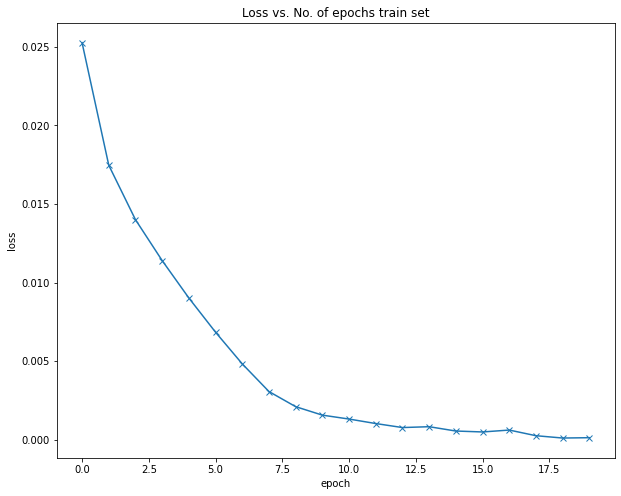

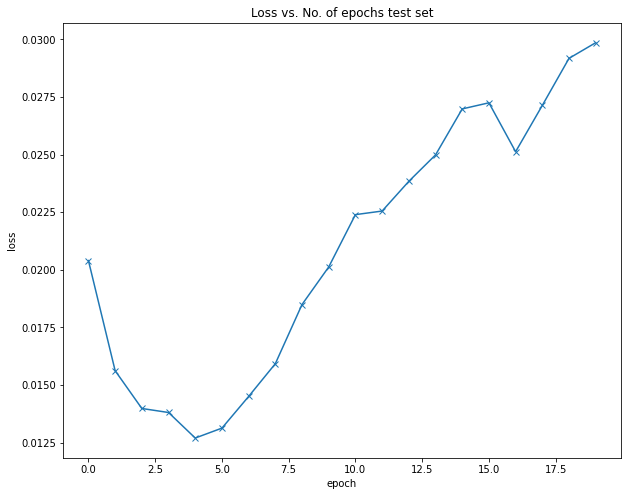

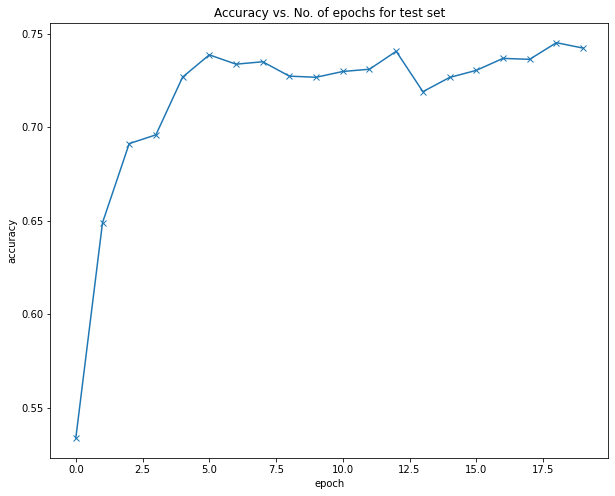

Accuracy after 20 epochs: 0.7423
Loss after 20 epochs: 0.029852502393722533


In [22]:
model = LeNet5(conv_layer_1=64, conv_layer_2=128, dense_layer_1=512, dense_layer_2=512, out_layer=10).to(device)
train_nn(model, num_epochs=20, learning_rate=0.01, momentum=0.9)

## Conclusion

So far the best model seems to be:  

**1st convolutional layer: 3 -> 64**  
**2nd convolutional layer: 64 -> 128**  
**1st layer: 36 * 128 -> 512**  
**2nd layer: 512 -> 512**  
**3rd layer: 512 -> 10**  
**learning_rate=0.01, momentum=0.9 for 20 epochs**  

Let's extract the filters of the 1st Convolutional Layer and the structure of this model.

### 1st Convolutional Layer Filters

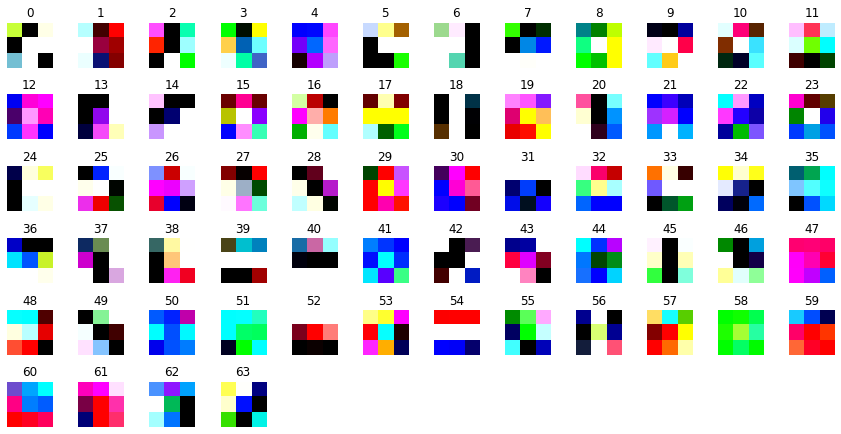

In [18]:
import numpy as np

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().data.numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
           
    plt.tight_layout()
    plt.show()

    
plot_filters_multi_channel(model.conv1.weight.data)

### Model Structure

In [19]:
print(model)

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

LeNet5(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dense1): Linear(in_features=4608, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=512, bias=True)
  (dense3): Linear(in_features=512, out_features=10, bias=True)
)
Layer: conv1.weight | Size: torch.Size([64, 3, 3, 3]) | Values : tensor([[[[ 1.1613e-01, -6.6382e-01,  2.2235e-01],
          [-4.3903e-01,  3.6674e-01,  3.0718e-01],
          [-1.1842e-02,  5.0024e-01, -4.9846e-01]],

         [[ 2.7742e-01, -5.5835e-01,  2.5999e-01],
          [-5.2689e-01,  3.9068e-01,  2.3969e-01],
          [ 1.0426e-01,  4.1482e-01, -3.9785e-01]],

         [[-1.0622e-01, -6.5661e-01,  1.6680e-01],
          [-4.7030e-01,  3.6906e-01,  5.9653e-01],
          [ 1.3447e-01,  3.9757e-01, -4.1021e-01]]],


        [[[ 5.7686e-02, -7.4600e-02,  3.2427e-01],
          [ 1.5932e-01,  2.5113e-02,  3.3065e-02],
          [ 1.1854e-01, -1.3990e-01,  2